<a href="https://colab.research.google.com/github/xper100/AIBootCamp-Project/blob/main/ai_sc22x_%EB%B0%95%EC%A3%BC%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC22x
 
### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [ ]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import warnings
warnings.filterwarnings(action='ignore')

import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [ ]:
# 데이터셋을 불러옵니다
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from scipy.stats import randint, uniform

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [ ]:
target =['shot_made_flag']
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season


In [ ]:
df.isnull().sum() # 결측치 없음

game_id              0
game_event_id        0
player_name          0
period               0
minutes_remaining    0
seconds_remaining    0
action_type          0
shot_type            0
shot_zone_basic      0
shot_zone_area       0
shot_zone_range      0
shot_distance        0
loc_x                0
loc_y                0
shot_made_flag       0
game_date            0
htm                  0
vtm                  0
season_type          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            30697 non-null  int64 
 1   game_event_id      30697 non-null  int64 
 2   player_name        30697 non-null  object
 3   period             30697 non-null  int64 
 4   minutes_remaining  30697 non-null  int64 
 5   seconds_remaining  30697 non-null  int64 
 6   action_type        30697 non-null  object
 7   shot_type          30697 non-null  object
 8   shot_zone_basic    30697 non-null  object
 9   shot_zone_area     30697 non-null  object
 10  shot_zone_range    30697 non-null  object
 11  shot_distance      30697 non-null  int64 
 12  loc_x              30697 non-null  int64 
 13  loc_y              30697 non-null  int64 
 14  shot_made_flag     30697 non-null  int64 
 15  game_date          30697 non-null  object
 16  htm                30697 non-null  objec

In [ ]:
df[target].value_counts(normalize = True)
# 대체적으로 잘 분포됨

shot_made_flag
0                 0.552692
1                 0.447308
dtype: float64

In [ ]:
# Base line은 0 (Fail to make a goal)
df[target].mode()

,shot_made_flag
0,0


In [ ]:
base_line = 0
base_accuracy = df[target].value_counts(normalize = True)[base_line].values
print("Baseline:",base_line)
print("The baseline accuracy score: ", base_accuracy)

Baseline: 0
The baseline accuracy score:  [0.55269245]


## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 **2014-15** ~ **2015-16** 시즌을 `test set`으로 만듭니다. NBA 시즌은 **10월**에 시작해서 **6월**에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [ ]:
df['game_date'] = pd.to_datetime(df['game_date'])

cond_test = ( (df['game_date'] >= '2014-10-01') & (df['game_date'] <= '2016-06-30') ) 

test = df[cond_test]
train = df[~cond_test]

train.shape, test.shape

((28871, 19), (1826, 19))

## 1.3 새로운 feature를 만드세요

> 최소 1개 이상의 새로운 feature를 만드세요. 아래의 리스트를 사용하셔도 되고 스스로의 아이디어로 만들어 주셔도 괜찮습니다.
>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [ ]:
def new_feature_engineering(df):
  # 홈 어드벤티지 여부(LAL)
  df['Homecourt_Advantage'] = df['htm'].apply(lambda x: 1 if x == 'LAL' else 0)

  # 상대팀명
  df['Opponent'] = (df['htm'] + df['vtm']).str.replace('LAL','')

  # 남은 시간(초)
  df['Seconds_remaining_in_the_period'] = (df['minutes_remaining']/60) + df['seconds_remaining']
  df['Seconds_remaining_in_the_game'] = ( df['period']*(12/60) ) + (df['minutes_remaining']/60) + df['seconds_remaining']

  # 예전 슛 성공여부
  df['Made_previous_shot'] = None
  for i in range(len(df)):
    if i == 0:
      df['Made_previous_shot'].loc[i] = df[target].iloc[i,0]
    else:
      df['Made_previous_shot'].loc[i] = df[target].iloc[i-1,0]

  # 불필요한 컬럼 제거
  delet_col = ['game_date' ,'game_event_id', 'player_name','period','minutes_remaining', 'seconds_remaining', 'htm', 'vtm']
  df.drop(delet_col, axis = 1, inplace = True)
  return df

train = pd.DataFrame(feature_engineering(train))
test = pd.DataFrame(feature_engineering(test))

## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [ ]:
X_test, y_test = test.drop(target, axis = 1), test[target]
X_train, X_val, y_train, y_val = train_test_split(train.drop(target, axis = 1), train[target], train_size = 0.8, test_size = 0.2, random_state = 42)

X_train.shape, X_val.shape, X_test.shape

((23096, 18), (5775, 18), (1826, 18))

# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [ ]:
pipe = make_pipeline(
                      TargetEncoder(smoothing = 2),
                      RandomForestClassifier(n_estimators = 100, max_depth = 10, criterion= 'gini', n_jobs = -1)
                      )

pipe.fit(X_train, y_train)
print("F1 Score:",pipe.score(X_train, y_train) )

F1 Score: 0.702632490474541


## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [ ]:
y_pred_val = pipe.predict(X_val)
print("Accuracy Score (Validation):",accuracy_score(y_pred_val, y_val))

Accuracy Score (Validation): 0.6938528138528138


## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [ ]:
y_pred_test = pipe.predict(X_test)
print("Accuracy Score (Validation):",accuracy_score(y_pred_test, y_test))

Accuracy Score (Validation): 0.6746987951807228


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

### a) Accuracy score를 계산하세요

In [ ]:
tn = 85
tp = 36
fn = 8
fp = 58 
total = (tn+tp+fn+fp)
accuracy = (tp+tn)/total
round(accuracy,4)

0.6471

### b) Precision score를 계산하세요 

In [ ]:
predicted_positive  = tp + fp
precision = tp/predicted_positive
round(precision,4)

0.383

### c) Recall score를 계산하세요

In [ ]:
real_positive = tp + fn
recall = tp / real_positive
round(recall,4)

0.8182

# Advanced Goals
>**3점**을 획득하기 위해선 아래 주어진 **모든 조건**을 만족해야합니다. 
- **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.
- `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.
- 최소 **3개**의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.
- `feature importance`를 계산하고 시각화 해주세요.

* 특성공학

In [ ]:
df_new = pd.read_csv(url)

def new_feature_engineering(df):
  # 홈 어드벤티지 여부(LAL)
  df['Homecourt_Advantage'] = df['htm'].apply(lambda x: 1 if x == 'LAL' else 0)

  # 상대팀명
  df['Opponent'] = (df['htm'] + df['vtm']).str.replace('LAL','')

  # 남은 시간(초)
  df['Seconds_remaining_in_the_period'] = (df['minutes_remaining']/60) + df['seconds_remaining']
  df['Seconds_remaining_in_the_game'] = ( df['period']*(12/60) ) + (df['minutes_remaining']/60) + df['seconds_remaining']

  # 예전 슛 성공여부
  df['Made_previous_shot'] = None
  for i in range(len(df)):
    if i == 0:
      df['Made_previous_shot'].loc[i] = df[target].iloc[i,0]
    else:
      df['Made_previous_shot'].loc[i] = df[target].iloc[i-1,0]

  # 불필요한 컬럼 제거
  delet_col = ['game_date', 'game_id', 'game_event_id', 'player_name','period','minutes_remaining', 'seconds_remaining', 'htm', 'vtm']
  df.drop(delet_col, axis = 1, inplace = True)
  return df



In [ ]:
df_new['game_date'] = pd.to_datetime(df_new['game_date'])

cond_test = ( (df_new['game_date'] >= '2014-10-01') & (df_new['game_date'] <= '2016-06-30') ) 

test = df_new[cond_test]
train = df_new[~cond_test]

In [ ]:
train = new_feature_engineering(train)
test = new_feature_engineering(test)

train.shape, test.shape

((28871, 15), (1826, 15))

In [ ]:
train.head()

,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,season_type,Homecourt_Advantage,Opponent,Seconds_remaining_in_the_period,Seconds_remaining_in_the_game,Made_previous_shot
0,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,Regular Season,1,MIN,42.000000,42.200000,0
1,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,Regular Season,0,NYK,8.166667,8.566667,0
2,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,Regular Season,0,CHH,37.133333,37.533333,0
3,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,Regular Season,0,CHH,34.100000,34.500000,1
4,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,Regular Season,0,CHH,27.083333,27.483333,0


* 시각화

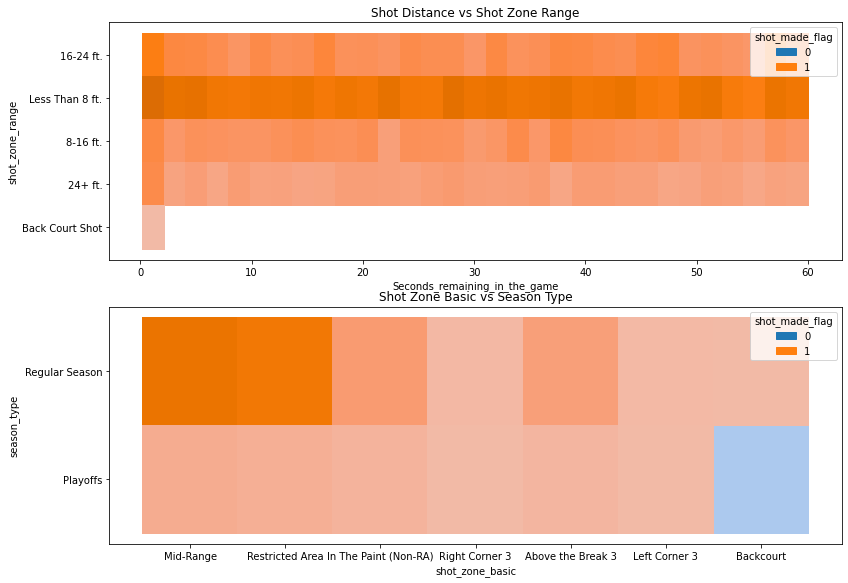

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(2,1, figsize = (12,8))

sns.histplot(data=train, x="Seconds_remaining_in_the_game", y="shot_zone_range", hue = 'shot_made_flag', ax = axes[0])
axes[0].set_title("Shot Distance vs Shot Zone Range")
fig.tight_layout()

sns.histplot(data=train, x="shot_zone_basic", y="season_type", hue = 'shot_made_flag', ax = axes[1])
axes[1].set_title("Shot Zone Basic vs Season Type")
plt.show()

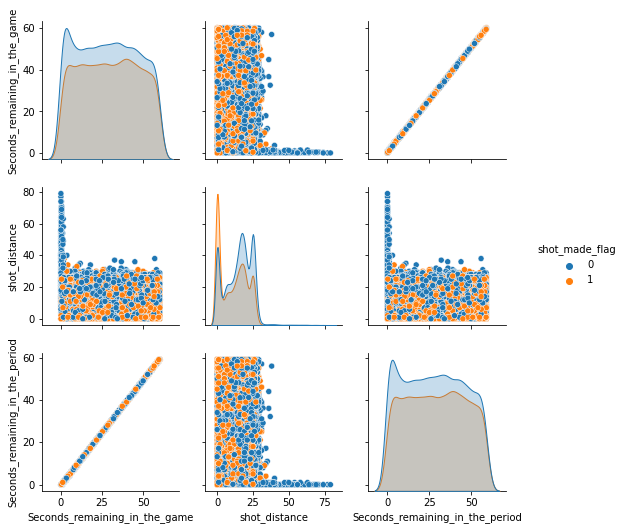

In [ ]:
col = ['Seconds_remaining_in_the_game', 'shot_distance', 'Seconds_remaining_in_the_period', 'shot_made_flag']
sns.pairplot(train[col], hue="shot_made_flag")

* 데이터 나누기

In [ ]:
X_test, y_test = test.drop(target, axis = 1), test[target]
X_train, X_val, y_train, y_val = train_test_split(train.drop(target, axis = 1), train[target], train_size = 0.8, test_size = 0.2, random_state = 42)

X_train.shape, X_val.shape, X_test.shape

((23096, 14), (5775, 14), (1826, 14))

* 모델링

In [ ]:
pipe_rf = make_pipeline(TargetEncoder(smoothing = 2),

                     RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)
                     )
param_dist = {
              "randomforestclassifier__max_depth": randint(10,40),
              'randomforestclassifier__max_features': uniform(0,1),
              # Sample갯수의 [0.001%, 0.1%]
              'randomforestclassifier__min_samples_split': randint(int(len(X_train)*0.0001),int(len(X_train)*0.001)),
              # Sample갯수의 [0.001%, 0.1%]
              'randomforestclassifier__min_samples_leaf': randint(int(len(X_train)*0.0001), int(len(X_train)*0.001)),

              }
              
random_grid = RandomizedSearchCV(pipe_rf,
                                 param_distributions = param_dist,
                                 n_iter = 5,
                                 scoring = 'f1',
                                 cv = 3,
                                 verbose = 1,
                                 n_jobs = -1
                                 )

random_grid.fit(X_train, y_train)
print("Best parameter:",random_grid.best_params_)
print('f1 score:: ', random_grid.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   33.8s finished


Best parameter: {'randomforestclassifier__max_depth': 31, 'randomforestclassifier__max_features': 0.46806069226334823, 'randomforestclassifier__min_samples_leaf': 21, 'randomforestclassifier__min_samples_split': 3}
f1 score::  0.5603328951973577


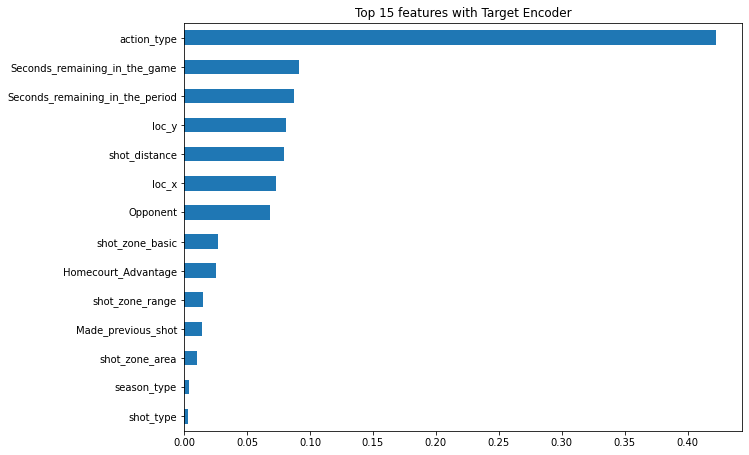

In [ ]:
import matplotlib.pyplot as plt
# Set the model with the best parameters obatined by Grid Search
best_rf_mod = random_grid.best_estimator_
# importance score
rf_mod = best_rf_mod.named_steps['randomforestclassifier']
importances = pd.Series(rf_mod.feature_importances_, X_train.columns)

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features with Target Encoder')
importances.sort_values()[-n:].plot.barh();